In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, ConvexHull
import geopandas as gpd
from scipy.spatial.distance import cdist
import geometry
import krige
from scipy import stats
import matplotlib as mpl
import matplotlib.cm as cm
from shapely.geometry import Point, MultiLineString, Polygon, MultiPolygon
from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import skimage

Load the wolfcamp aquifer data from http://wiki.stat.ucla.edu/socr/index.php/SOCR_061708_NC_Data_Aquifer:

In [2]:
df = pd.read_excel('wolfcamp.xlsx')
df.head()

,X,Y,Data
0,42.78275,127.62282,1.464
1,-27.39691,90.78732,2.553
2,-1.16289,84.89600,2.158
3,-18.61823,76.45199,2.455
4,96.46549,64.58058,1.756


In [3]:
X = df[['X', 'Y']].values
y = df['Data'].values

Create the model nodes seperated by 5 km:

In [4]:
extent = [X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()]
cellsize = 5
nx, ny = int(np.abs(extent[0] - extent[1]) / cellsize), int(np.abs(extent[2] - extent[3]) / cellsize)
xi = np.linspace(extent[0], extent[1], nx)
yi = np.linspace(X[:, 1].min(), X[:, 1].max(), ny)
xi, yi = np.meshgrid(xi, yi)
Xnew = np.vstack((xi.flatten(), yi.flatten())).T
mask = Delaunay(X).find_simplex(Xnew)>=0
Xnew = Xnew[mask]


In [5]:
vertices = X[ConvexHull(X).vertices]
boundary = Polygon([Point(p) for p in vertices])

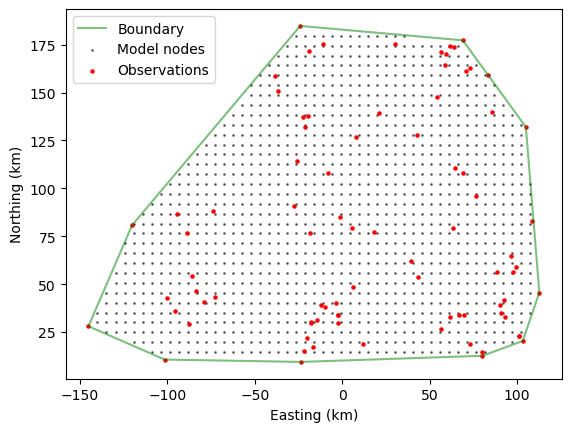

In [6]:
plt.close()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c='k', alpha=0.5, s=1, label='Model nodes')
plt.scatter(X[:, 0], X[:, 1], c='r', s=5, label='Observations')
plt.plot(boundary.exterior.xy[0], boundary.exterior.xy[1], c='Green', alpha=0.5, label='Boundary')
plt.xlabel('Easting (km)')
plt.ylabel('Northing (km)')
plt.legend()
plt.savefig('model-domain.png', dpi=300)
plt.show()

Get variogram paramters externally in r:

In [7]:
alpha, l, sigma =  0.009861804, 19.42753, 0.029436583

Generate realisations of head and partial derivatives:

In [8]:
nrealisations = 100
run = False

In [9]:
if run:
    f = krige.FunctionRealisation(X, Xnew, y, [l, sigma], nrealisations, alpha, 500)
    np.save('export/f.npy', f)
    dx, dy, dxx, dyy, dxy = krige.DerivativeRealisation(X, Xnew, y, f, [l, sigma], nrealisations, alpha, 500)
    np.save('export/dx.npy', dx)
    np.save('export/dy.npy', dy)
    np.save('export/dxx.npy', dxx)
    np.save('export/dyy.npy', dyy)
    np.save('export/dxy.npy', dxy)
else:
    f = np.load('export/f.npy')
    dx = np.load('export/dx.npy')
    dy = np.load('export/dy.npy')
    dxx = np.load('export/dxx.npy')
    dyy = np.load('export/dyy.npy')
    dxy = np.load('export/dxy.npy')

100%|██████████| 100/100 [50:46<00:00, 30.47s/it]


Plot the first two realisations (a and b) and the mean/std of all realisations (c):

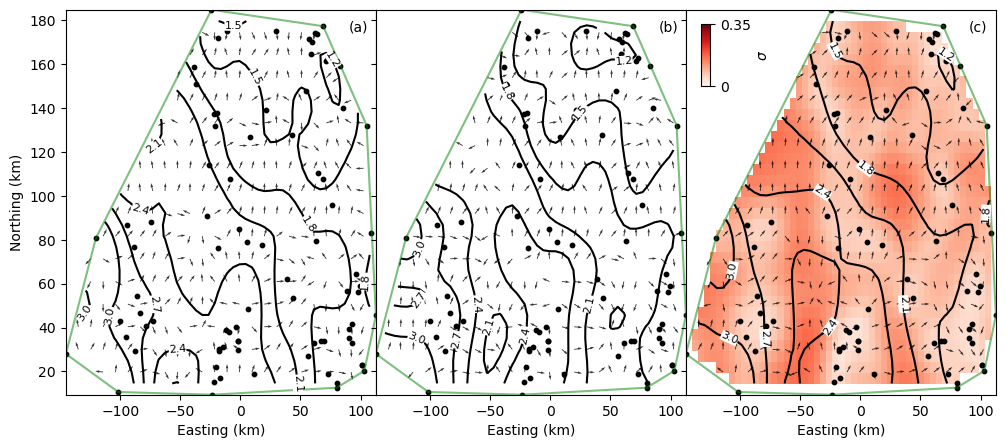

In [10]:
plt.close()
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(12, 5))
for i in range(2):
    cs = ax[i].contour(geometry.make_grid(f[i], mask.reshape(ny, nx)), colors='k', extent=extent)#, levels=np.arange(200, 410, 10)
    clabels = ax[i].clabel(cs, inline=0, fontsize=8, fmt='%1.1f')
    [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
    theta = np.arctan2(-dy[i], -dx[i]) 
    stride = 2
    ax[i].quiver(xi[::stride,::stride], yi[::stride,::stride], geometry.make_grid(np.cos(theta), mask.reshape(ny, nx))[::stride,::stride], geometry.make_grid(np.sin(theta), mask.reshape(ny, nx))[::stride,::stride], color='k', angles='xy', alpha=0.8)

cs = ax[2].contour(geometry.make_grid(f.mean(axis=0), mask.reshape(ny, nx)), colors='k', extent=extent)#, levels=np.arange(200, 410, 10)
clabels = ax[2].clabel(cs, inline=0, fontsize=8, fmt='%1.1f')
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
theta = np.arctan2(-dy.mean(axis=0), -dx.mean(axis=0)) 
stride = 2
ax[2].quiver(xi[::stride,::stride], yi[::stride,::stride], geometry.make_grid(np.cos(theta), mask.reshape(ny, nx))[::stride,::stride], geometry.make_grid(np.sin(theta), mask.reshape(ny, nx))[::stride,::stride], color='k', angles='xy', alpha=0.8)
im = ax[2].imshow(geometry.make_grid(f.std(axis=0), mask.reshape(ny, nx)), extent=[extent[0], extent[1], extent[3], extent[2]], cmap='Reds', aspect='auto', vmin=0, vmax=0.35)
cbaxes = inset_axes(ax[2], width="15%", height="80%", bbox_to_anchor=(-0.1,1-0.22,.2,.2), bbox_transform=ax[2].transAxes)
cbar = plt.colorbar(im, cax=cbaxes, orientation='vertical', label='$\sigma$')
cbar.set_ticks([0, 0.35])
cbar.set_ticklabels(['0', '0.35'])
ax[0].set_ylabel('Northing (km)')
label = ['a', 'b', 'c']
for i in range(3):
    ax[i].set_xlim(extent[0], extent[1])
    ax[i].set_ylim(extent[2], extent[3])
    ax[i].set_xlabel('Easting (km)')
    ax[i].annotate("({})".format(label[i]), xy=(90, 175))
    ax[i].plot(boundary.exterior.xy[0], boundary.exterior.xy[1], c='Green', alpha=0.5)
    ax[i].scatter(X[:, 0], X[:, 1], c='k', s=10)
fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("hydraulic_head.png", dpi=300, bbox_inches='tight')
plt.show()

Find edge nodes and get angle of each nodes projection onto the boundary:

In [11]:
buff = boundary.exterior.buffer(4.9)
edges = np.array([buff.contains(Point(p)) for p in Xnew])
vertices = np.array([c for c in boundary.buffer(0.1).exterior.coords])
P1 = vertices[:-1]
P2 = vertices[1:]
_theta_ = np.array([geometry.projection(P1[:, 0], P1[:, 1], P2[:, 0], P2[:, 1], *p)[1] for p in Xnew[edges]])

Find extrema and buffer 5000 m:

In [12]:
extrema = np.zeros(dx.shape)
for i in tqdm(range(nrealisations)):
    cx = geometry.contours(geometry.make_grid(dx[i], mask.reshape(ny, nx)), 0, *extent)
    cy = geometry.contours(geometry.make_grid(dy[i], mask.reshape(ny, nx)), 0, *extent)
    buffer = 5
    intersect = MultiLineString(cx).intersection(MultiLineString(cy))
    intersect = intersect.buffer(buffer)
    coords = Xnew[np.array([intersect.contains(Point(p)) for p in Xnew])]#np.array([(p.x, p.y) for p in intersect])
    indx = [np.argmin(np.abs(xi[0, :] - c)) for c in coords[:, 0]]
    indy = [np.argmin(np.abs(yi[:, 0] - c)) for c in coords[:, 1]]
    out = np.zeros(mask.reshape(ny, nx).shape)
    out[indy, indx] = 1
    extrema[i] = out[mask.reshape(ny, nx)]

100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Apply second derivative test to assess inflection, minima, maxima and concavity:

In [13]:
H, classification = krige.SecondDerivativeTest(dxx, dyy, dxy)
classification = classification * extrema #only get the classification at the critical points

In [14]:
minima = classification.copy()
minima[minima != 3] = 0
minima = minima/3
maxima = classification.copy()
maxima[maxima != 2] = 0
maxima = maxima/2

Find the resultant of the flow vector relative to the edge of the boundary and whether it is in or out:

In [15]:
edge_effects = np.array([geometry.resultant(dx[i, edges], dy[i, edges], _theta_) for i in range(nrealisations)])
edge_effects[np.abs(edge_effects) < 1e-8] = 0 
recharge_edges = edge_effects.copy()
recharge_edges[recharge_edges < 0] = 0
recharge_edges[recharge_edges > 0] = 1
discharge_edges = edge_effects.copy()
discharge_edges[discharge_edges > 0] = 0
discharge_edges[discharge_edges < 0] = 1
minima[:, edges] = discharge_edges
maxima[:, edges] = recharge_edges

Find concave up and concave down areas:

In [16]:
concave_up = np.zeros(H.shape)
concave_up[(H > 0) & (dxx > 0)] = 1
concave_down = np.zeros(H.shape)
concave_down[(H > 0) & (dxx < 0)] = 1

Plot two realisations of extrema (a and b) and the relative percentage of nodes that are extrema (c):

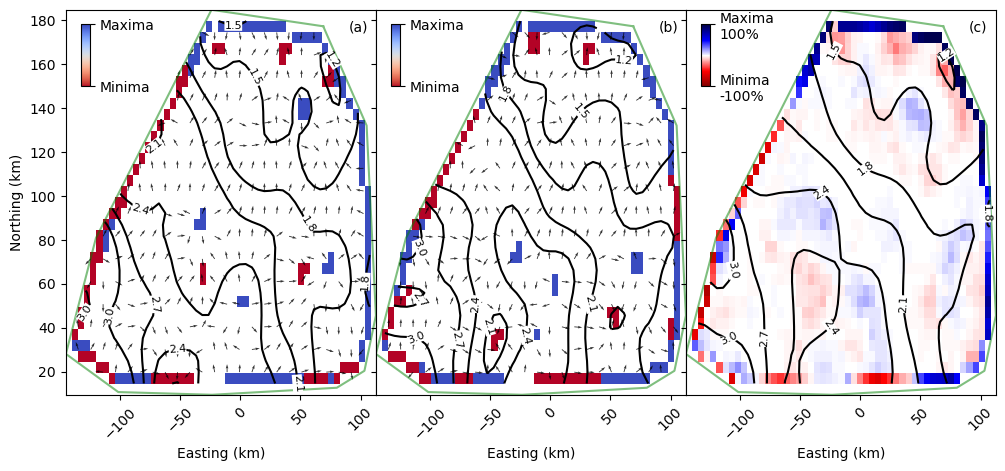

In [19]:
plt.close()
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(12, 5))
for i in range(2):
    cs = ax[i].contour(geometry.make_grid(f[i], mask.reshape(ny, nx)), colors='k', extent=extent)#, levels=np.arange(200, 410, 10)
    clabels = ax[i].clabel(cs, inline=0, fontsize=8, fmt='%1.1f')
    [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
    theta = np.arctan2(-dy[i], -dx[i]) 
    stride = 2
    ax[i].quiver(xi[::stride,::stride], yi[::stride,::stride], geometry.make_grid(np.cos(theta), mask.reshape(ny, nx))[::stride,::stride], geometry.make_grid(np.sin(theta), mask.reshape(ny, nx))[::stride,::stride], color='k', angles='xy', alpha=0.8)
    im = ax[i].imshow(geometry.make_grid(np.where((maxima[i] - minima[i])==0, np.nan, (maxima[i] - minima[i])), mask.reshape(ny, nx)), extent=[extent[0], extent[1], extent[3], extent[2]], cmap='coolwarm_r', aspect='auto')
    cbaxes = inset_axes(ax[i], width="15%", height="80%", bbox_to_anchor=(-0.1,1-0.22,.2,.2), bbox_transform=ax[i].transAxes)
    cbar = plt.colorbar(im, cax=cbaxes, orientation='vertical')
    cbar.set_ticks([1, -1])
    cbar.set_ticklabels(['Maxima', 'Minima'])
    

im = ax[2].imshow(geometry.make_grid(np.where((maxima - minima).mean(axis=0)==0, np.nan, (maxima - minima).mean(axis=0)), mask.reshape(ny, nx)), extent=[extent[0], extent[1], extent[3], extent[2]], cmap='seismic_r', aspect='auto', vmin=-1, vmax=1)
cbaxes = inset_axes(ax[2], width="15%", height="80%", bbox_to_anchor=(-0.1,1-0.22,.2,.2), bbox_transform=ax[2].transAxes)
cbar = plt.colorbar(im, cax=cbaxes, orientation='vertical')
cbar.set_ticks([1, -1])
cbar.set_ticklabels(['Maxima\n100%', 'Minima\n-100%'])
cs = ax[2].contour(geometry.make_grid(f.mean(axis=0), mask.reshape(ny, nx)), colors='k',  extent=extent)
clabels=ax[2].clabel(cs, inline=0, fontsize=8, fmt='%1.1f')
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

ax[0].set_ylabel('Northing (km)')
label = ['a', 'b', 'c']
for i in range(3):
    ax[i].set_xlabel('Easting (km)')
    ax[i].set_xlim(extent[0], extent[1])
    ax[i].set_ylim(extent[2], extent[3])
    ax[i].tick_params(labelrotation=45, axis='x')
    ax[i].annotate("({})".format(label[i]), xy=(90, 175))
    ax[i].plot(boundary.exterior.xy[0], boundary.exterior.xy[1], c='Green', alpha=0.5)


fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("extrema.png", dpi=300, bbox_inches='tight')
plt.show()

Plot the concavity for two realisations (a and b) and the relative proportion of realisations concave up/concave down (c):

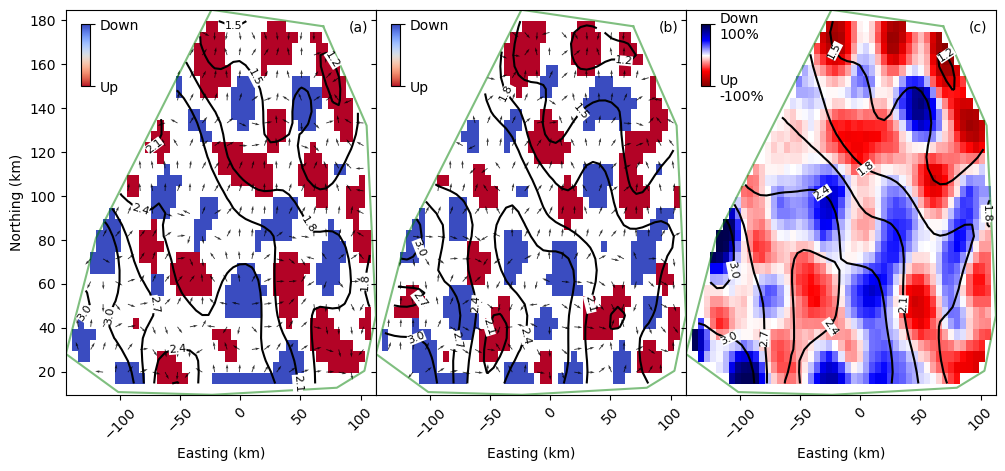

In [20]:
plt.close()
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(12, 5))
for i in range(2):
    cs = ax[i].contour(geometry.make_grid(f[i], mask.reshape(ny, nx)), colors='k', extent=extent)#, levels=np.arange(200, 410, 10)
    clabels = ax[i].clabel(cs, inline=0, fontsize=8, fmt='%1.1f')
    [txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]
    theta = np.arctan2(-dy[i], -dx[i]) 
    stride = 2
    ax[i].quiver(xi[::stride,::stride], yi[::stride,::stride], geometry.make_grid(np.cos(theta), mask.reshape(ny, nx))[::stride,::stride], geometry.make_grid(np.sin(theta), mask.reshape(ny, nx))[::stride,::stride], color='k', angles='xy', alpha=0.8)
    im = ax[i].imshow(geometry.make_grid(np.where((concave_down[i] - concave_up[i])==0, np.nan, (concave_down[i] - concave_up[i])), mask.reshape(ny, nx)), extent=[extent[0], extent[1], extent[3], extent[2]], cmap='coolwarm_r', aspect='auto')
    cbaxes = inset_axes(ax[i], width="15%", height="80%", bbox_to_anchor=(-0.1,1-0.22,.2,.2), bbox_transform=ax[i].transAxes)
    cbar = plt.colorbar(im, cax=cbaxes, orientation='vertical')
    cbar.set_ticks([1, -1])
    cbar.set_ticklabels(['Down', 'Up'])
    

im = ax[2].imshow(geometry.make_grid(np.where((concave_down - concave_up).mean(axis=0)==0, np.nan, (concave_down - concave_up).mean(axis=0)), mask.reshape(ny, nx)), extent=[extent[0], extent[1], extent[3], extent[2]], cmap='seismic_r', aspect='auto', vmin=-1, vmax=1)
cbaxes = inset_axes(ax[2], width="15%", height="80%", bbox_to_anchor=(-0.1,1-0.22,.2,.2), bbox_transform=ax[2].transAxes)
cbar = plt.colorbar(im, cax=cbaxes, orientation='vertical')
cbar.set_ticks([1, -1])
cbar.set_ticklabels(['Down\n100%', 'Up\n-100%'])
cs = ax[2].contour(geometry.make_grid(f.mean(axis=0), mask.reshape(ny, nx)), colors='k',  extent=extent)
clabels=ax[2].clabel(cs, inline=0, fontsize=8, fmt='%1.1f')
[txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0)) for txt in clabels]

ax[0].set_ylabel('Northing (km)')
label = ['a', 'b', 'c']
for i in range(3):
    ax[i].set_xlabel('Easting (km)')
    ax[i].set_xlim(extent[0], extent[1])
    ax[i].set_ylim(extent[2], extent[3])
    ax[i].tick_params(labelrotation=45, axis='x')
    ax[i].annotate("({})".format(label[i]), xy=(90, 175))
    ax[i].plot(boundary.exterior.xy[0], boundary.exterior.xy[1], c='Green', alpha=0.5)


fig.subplots_adjust(wspace=0, hspace=0)
plt.savefig("concavity.png", dpi=300, bbox_inches='tight')
plt.show()